## Face and Facial Keypoint detection

After We have trained a neural network to detect facial keypoints, we can then apply this network to *any* image that includes faces. The neural network expects a Tensor of a certain size as input and, so, to detect any face, you'll first have to do some pre-processing.

1. Detect all the faces in an image using a face detector (we'll be using a Haar Cascade detector in this notebook).
2. Pre-process those face images so that they are grayscale, and transformed to a Tensor of the input size that your net expects. This step will be similar to the `data_transform` we created and applied in Notebook 2, whose job was tp rescale, normalize and turn any image into a Tensor to be accepted as input to your CNN.
3. Use your trained model to detect facial keypoints on the image.

---

In the next python cell we load in required libraries for this section of the project.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

#### Select an image 

Select an image to perform facial keypoint detection on; you can select any image of faces in the `images/` directory.

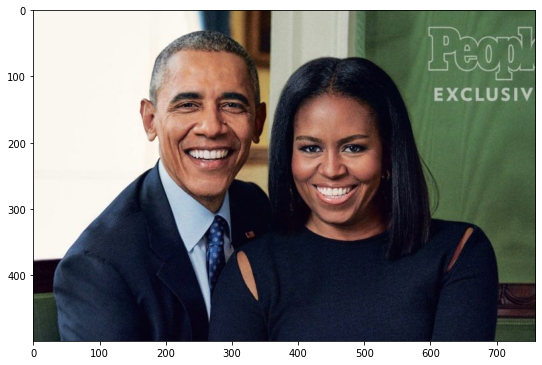

In [2]:
import cv2
## load in color image for face detection
image = cv2.imread('images/obamas.jpg')

# switch red and blue color channels 
# --> by default OpenCV assumes BLUE comes first, not RED as in many images
gray = image.copy()
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

# plot the image
fig = plt.figure(figsize=(9,9))
plt.imshow(image)

## Detect all faces in an image

Next, we will use one of OpenCV's pre-trained Haar Cascade classifiers, all of which can be found in the `detector_architectures/` directory, to find any faces in your selected image.

In the code below, we loop over each face in the original image and draw a red square on each face (in a copy of the original image, so as not to modify the original). 

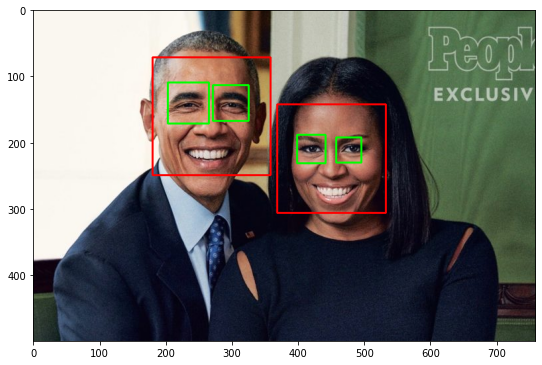

In [3]:
# load in a haar cascade classifier for detecting frontal faces
face_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_frontalface_default.xml')

# load in a haar cascade classifier for detecting eyes
eye_cascade = cv2.CascadeClassifier('detector_architectures/haarcascade_eye.xml')

# run the detector
# the output here is an array of detections; the corners of each detection box
# if necessary, modify these parameters until you successfully identify every face in a given image
gray = cv2.cvtColor(gray, cv2.COLOR_BGR2GRAY)
faces = face_cascade.detectMultiScale(gray, 1.3, 5)

# make a copy of the original image to plot detections on
image_with_detections = image.copy()

# loop over the detected faces, mark the image where each face is found
for (x,y,w,h) in faces:
    # draw a rectangle around each detected face
    # you may also need to change the width of the rectangle drawn depending on image resolution
    cv2.rectangle(image_with_detections,(x,y),(x+w,y+h),(255,0,0),2) #2
    
    # draw a rectangle around each detected eyes
    roi_gray = gray[y:y+h, x:x+w]
    roi_color = image_with_detections[y:y+h, x:x+w]
    eyes = eye_cascade.detectMultiScale(roi_gray)
    
    for (ex,ey,ew,eh) in eyes:
        cv2.rectangle(roi_color,(ex,ey),(ex+ew,ey+eh),(0,255,0),2)

fig = plt.figure(figsize=(9,9))

plt.imshow(image_with_detections)

## Loading in a trained model

Once we have an image to work with, the next step is to pre-process that image and feed it into your CNN facial keypoint detector.

First, load your best model by its filename.

In [5]:
import torch
from torch import nn
from torch.autograd import Variable
from models import Net

net = Net()

## load the best saved model parameters (by your path name)
## You'll need to un-comment the line below and add the correct name for *your* saved model
net.load_state_dict(torch.load('saved_models/keypoints_model_1.pt'))

## print out your net and prepare it for testing (uncomment the line below)
net.eval()

Net(
  (conv1): Conv2d(1, 32, kernel_size=(5, 5), stride=(1, 1))
  (bn1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool1): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1))
  (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1))
  (bn3): BatchNorm2d(128, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (conv4): Conv2d(128, 300, kernel_size=(3, 3), stride=(1, 1))
  (bn4): BatchNorm2d(300, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (pool4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=43200, out_features

## Keypoint detection

Now, we'll loop over each detected face in an image (again!) only this time, you'll transform those faces in Tensors that your CNN can accept as input images.

### Transform each detected face into an input Tensor

You'll need to perform the following steps for each detected face:
1. Convert the face from RGB to grayscale
2. Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
3. Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
4. Reshape the numpy image into a torch image.

**Hint**: The sizes of faces detected by a Haar detector and the faces your network has been trained on are of different sizes. If you find that your model is generating keypoints that are too small for a given face, try adding some padding to the detected `roi` before giving it as input to your model.

You may find it useful to consult to transformation code in `data_load.py` to help you perform these processing steps.


### Detect and display the predicted keypoints

After each face has been appropriately converted into an input Tensor for your network to see as input, you can apply your `net` to each face. The ouput should be the predicted the facial keypoints. These keypoints will need to be "un-normalized" for display, and you may find it helpful to write a helper function like `show_keypoints`. You should end up with an image like the following with facial keypoints that closely match the facial features on each individual face

In [8]:
def show_all_keypoints(image, keypoints):  
    batch_size = len(image)
    for i, face in enumerate(image):
        plt.figure(figsize=(8, 8))
        ax = plt.subplot(1, batch_size, i+1)

        # un-transform the predicted key_pts data
        predicted_keypoints = keypoints[i].data
        predicted_keypoints = predicted_keypoints.numpy()
        # undo normalization of keypoints  
        predicted_keypoints = predicted_keypoints*50.0+100

        plt.imshow(face, cmap='gray')
        plt.scatter(predicted_keypoints[:, 0], predicted_keypoints[:, 1], s=20, marker='.', c='m')
        
        #plt.axis('off')

    plt.show()

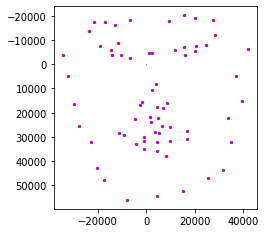

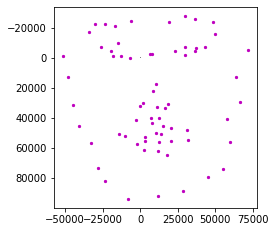

In [9]:
image_copy = np.copy(image)
#Including a padding to extract face as  HAAR classifier's bounding box, crops sections of the face

PADDING = 40
images, keypoints = [], []

# loop over the detected faces from your haar cascade
for (x,y,w,h) in faces:
    
    # Select the region of interest that is the face in the image 
    roi = image_copy[y-PADDING:y+h+PADDING, x-PADDING:x+w+PADDING]
    
    ## Convert the face region from RGB to grayscale
    roi = cv2.cvtColor(roi, cv2.COLOR_RGB2GRAY)
    
    ## Normalize the grayscale image so that its color range falls in [0,1] instead of [0,255]
    roi = (roi / 255.).astype(np.float32)
    
    ## Rescale the detected face to be the expected square size for your CNN (224x224, suggested)
    roi = cv2.resize(roi, (224, 224))
    images.append(roi)
    
    ## Reshape the numpy image shape (H x W x C) into a torch image shape (C x H x W)
    if len(roi.shape) == 2:
        roi = np.expand_dims(roi, axis=0)
    else:
        roi = np.rollaxis(roi, 2, 0)
        
    # Match the convolution dimensions
    roi = np.expand_dims(roi, axis=0)
    
    ## Make facial keypoint predictions using your loaded, trained network 
    # Forward pass
    roi = torch.from_numpy(roi).type(torch.FloatTensor)
    output_pts = net.forward(roi)
    
    output_pts = output_pts.view(output_pts.size()[0], 68, -1)
    keypoints.append(output_pts[0])
    
## Display each detected face and the corresponding keypoints
show_all_keypoints(images, keypoints)